In [1]:
import os
import cv2
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
gpu_device = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU = {len(gpu_device)}")
tf.config.experimental.set_memory_growth(gpu_device[0], True)

Number of GPU = 1


In [3]:
SEED = 1000
IMG_SIZE = 224
BATCH_SIZE = 64

TRAIN_DIR = '../input/bird-species-classification-220-categories/Train'

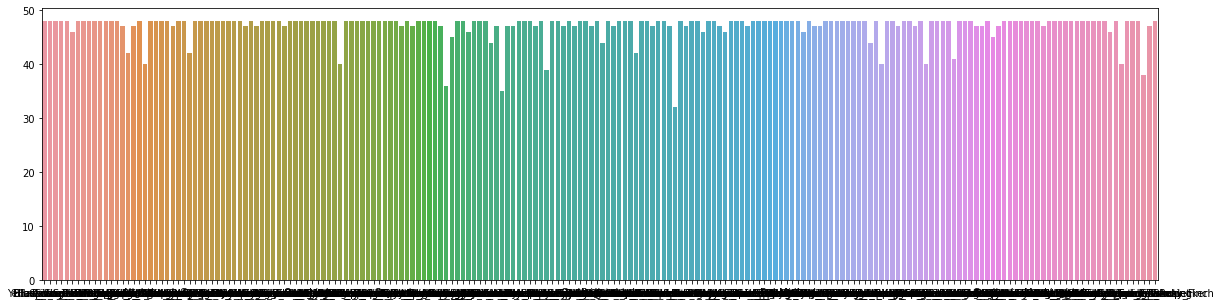

In [4]:
class_names = []
class_count = []
train_examples = 0
for f in os.listdir(TRAIN_DIR):
  files = gb.glob(pathname=str(TRAIN_DIR + "//" + f + "/*"))
  class_names.append(f)
  class_count.append(len(files))
  train_examples += len(files)
plt.figure(figsize=(20,5))
sns.barplot(x=class_names, y=class_count)
plt.show()

In [5]:
train_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

In [6]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode = 'categorical',
    seed=SEED
)

Found 6662 images belonging to 200 classes.


In [7]:
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode = 'categorical',
    seed=SEED
)

Found 2752 images belonging to 200 classes.


In [8]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE) + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
base_model.trainable = False

In [11]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.4)(x)


outputs = tf.keras.layers.Dense(200, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2048)              1050624   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              419635

In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
#     loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=10, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
h = model.fit(train_batch, 
              epochs=100,
              steps_per_epoch = 6662 // BATCH_SIZE,
              validation_data = valid_batch,
              validation_steps = 2752 // BATCH_SIZE,
              callbacks=[cb, reduce_lr]
             )

Epoch 1/100
104/104 [==============================] - 178s 2s/step - loss: 5.7393 - accuracy: 0.0065 - val_loss: 5.3541 - val_accuracy: 0.0047
Epoch 2/100
104/104 [==============================] - 142s 1s/step - loss: 5.5839 - accuracy: 0.0106 - val_loss: 5.3931 - val_accuracy: 0.0051
Epoch 3/100
104/104 [==============================] - 142s 1s/step - loss: 5.4345 - accuracy: 0.0170 - val_loss: 5.3586 - val_accuracy: 0.0080

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/100
104/104 [==============================] - 143s 1s/step - loss: 5.3441 - accuracy: 0.0185 - val_loss: 5.2913 - val_accuracy: 0.0120
Epoch 5/100
104/104 [==============================] - 143s 1s/step - loss: 5.3146 - accuracy: 0.0205 - val_loss: 5.2259 - val_accuracy: 0.0196
Epoch 6/100
104/104 [==============================] - 142s 1s/step - loss: 5.2990 - accuracy: 0.0236 - val_loss: 5.2157 - val_accuracy: 0.0178
Epoch 7/100
104/104 [==============================] -

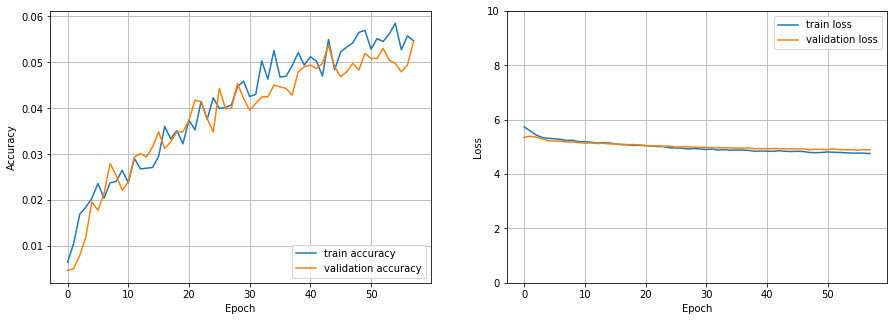

In [15]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],  label='train accuracy')
plt.plot(h.history['val_accuracy'],  label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'],  label='train loss')
plt.plot(h.history['val_loss'],  label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0,10])
plt.legend(loc='upper right')
plt.savefig ("VGG16.pdf",dpi=300)
plt.show()